# Signal Processing Pipeline Debug
Extracted from `scripts/signal_processing.py` for iteration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt, iirnotch, tf2sos, freqz
from scipy.ndimage import gaussian_filter

plt.style.use('dark_background')
%matplotlib inline

## Load Data

In [ ]:
DIFFICULTY = "easy"  # Change to super_easy, easy, medium, hard
MAX_SECONDS = 30  # Limit data to prevent OOM

data = pd.read_parquet(f"data/{DIFFICULTY}/track2_data.parquet")
# Limit to first N seconds to avoid OOM
max_samples = int(MAX_SECONDS * 500)
data = data.iloc[:max_samples]

ground_truth = pd.read_parquet(f"data/{DIFFICULTY}/ground_truth.parquet")
ground_truth = ground_truth[ground_truth['time_s'] <= MAX_SECONDS]

print(f"Data shape: {data.shape}")
print(f"Time range: {data.index.min():.2f}s to {data.index.max():.2f}s")
print(f"Sampling rate: {1 / (data.index[1] - data.index[0]):.1f} Hz")

In [ ]:
# Convert to numpy for processing (float32 to save memory)
fs = 500.0
neural = data.values.astype(np.float32)  # float32 halves memory
times = data.index.values
del data  # Free DataFrame memory

print(f"Neural data: {neural.shape}, dtype: {neural.dtype}")
print(f"Value range: [{neural.min():.4f}, {neural.max():.4f}]")

## Ground Truth - Where Are the Tuned Regions?

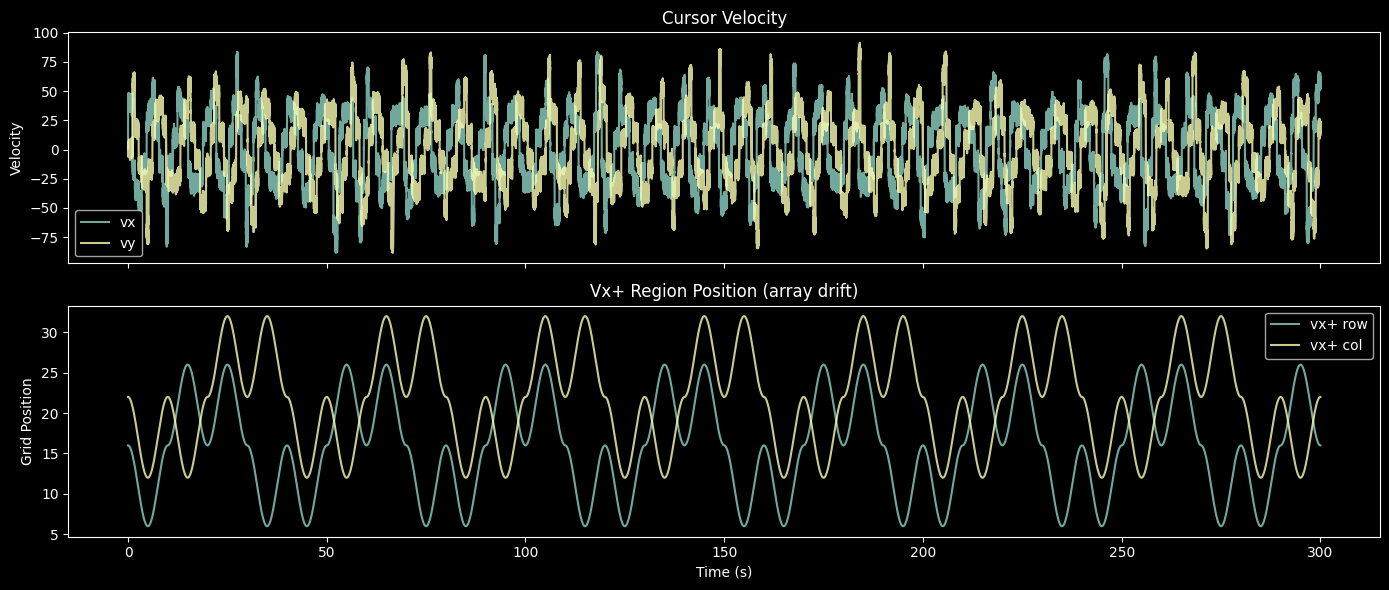

In [4]:
# Plot ground truth positions over time
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

gt_times = ground_truth['time_s'].values

# Velocity
axes[0].plot(gt_times, ground_truth['vx'], label='vx', alpha=0.8)
axes[0].plot(gt_times, ground_truth['vy'], label='vy', alpha=0.8)
axes[0].set_ylabel('Velocity')
axes[0].legend()
axes[0].set_title('Cursor Velocity')

# Region centers (pick one, e.g., vx_pos)
axes[1].plot(gt_times, ground_truth['vx_pos_center_row'], label='vx+ row', alpha=0.8)
axes[1].plot(gt_times, ground_truth['vx_pos_center_col'], label='vx+ col', alpha=0.8)
axes[1].set_ylabel('Grid Position')
axes[1].set_xlabel('Time (s)')
axes[1].legend()
axes[1].set_title('Vx+ Region Position (array drift)')

plt.tight_layout()
plt.show()

## Step 1: Bandpass Filter (70-150 Hz)

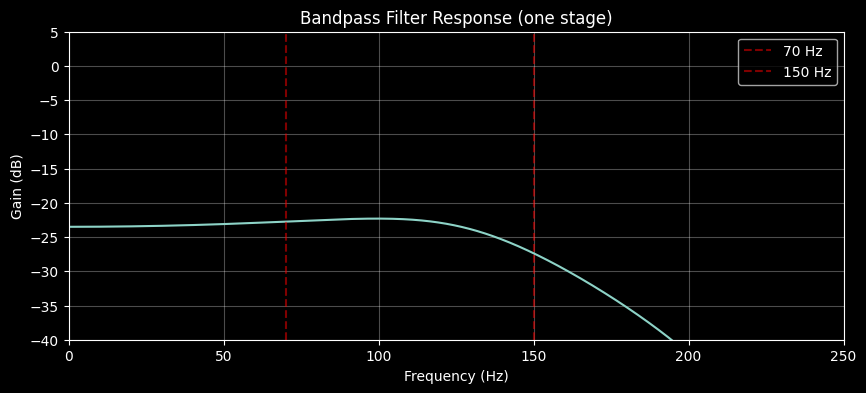

In [5]:
def make_bandpass(lowcut=70, highcut=150, fs=500, order=4):
    """Create bandpass filter coefficients."""
    sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
    return sos

# Check frequency response
sos = make_bandpass()
w, h = freqz(sos[0, :3], sos[0, 3:], worN=2000, fs=fs)

plt.figure(figsize=(10, 4))
plt.plot(w, 20 * np.log10(np.abs(h) + 1e-10))
plt.axvline(70, color='r', linestyle='--', alpha=0.5, label='70 Hz')
plt.axvline(150, color='r', linestyle='--', alpha=0.5, label='150 Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.title('Bandpass Filter Response (one stage)')
plt.xlim(0, 250)
plt.ylim(-40, 5)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
# Apply bandpass filter
sos = make_bandpass(lowcut=70, highcut=150, fs=fs, order=4)
filtered = sosfilt(sos, neural, axis=0)

print(f"Filtered shape: {filtered.shape}")
print(f"Filtered range: [{filtered.min():.6f}, {filtered.max():.6f}]")

Filtered shape: (150000, 1024)
Filtered range: [-1.752338, 1.521978]


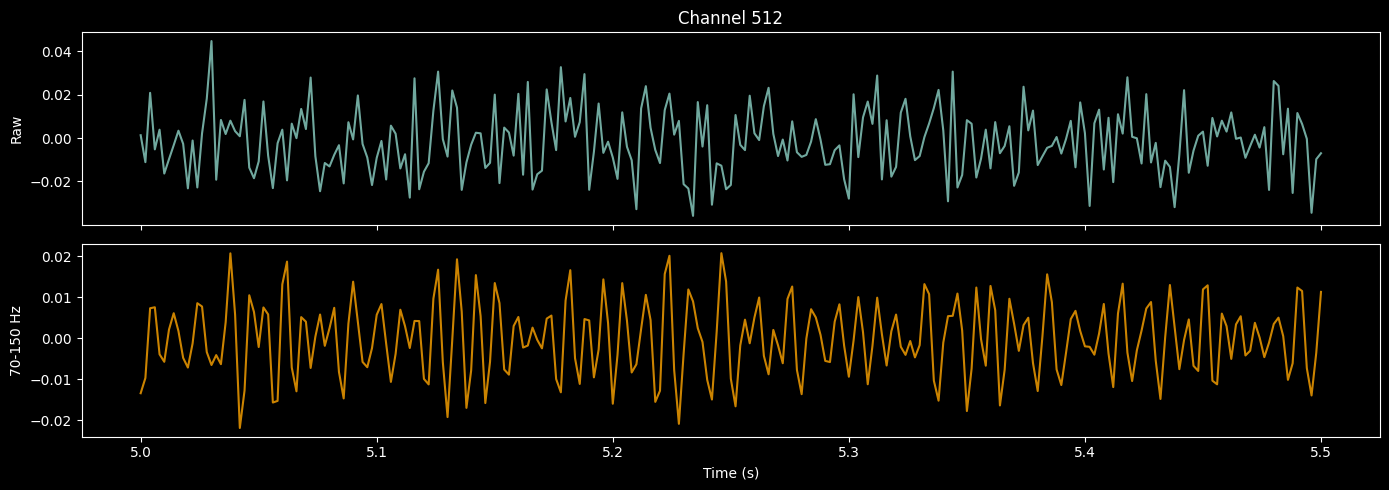

In [7]:
# Compare raw vs filtered for a single channel
ch = 512  # middle channel
t_start, t_end = 5.0, 5.5  # 500ms window
idx = (times >= t_start) & (times <= t_end)

fig, axes = plt.subplots(2, 1, figsize=(14, 5), sharex=True)
axes[0].plot(times[idx], neural[idx, ch], alpha=0.8)
axes[0].set_ylabel('Raw')
axes[0].set_title(f'Channel {ch}')

axes[1].plot(times[idx], filtered[idx, ch], alpha=0.8, color='orange')
axes[1].set_ylabel('70-150 Hz')
axes[1].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

## Step 2: Power Extraction

In [8]:
# Instantaneous power (squared amplitude)
power_instant = filtered ** 2

# Smooth with sliding window (e.g., 100ms = 50 samples)
window_samples = 50
kernel = np.ones(window_samples) / window_samples
power_smooth = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), 0, power_instant)

print(f"Power shape: {power_smooth.shape}")
print(f"Power range: [{power_smooth.min():.8f}, {power_smooth.max():.8f}]")

Power shape: (150000, 1024)
Power range: [0.00000226, 0.33365253]


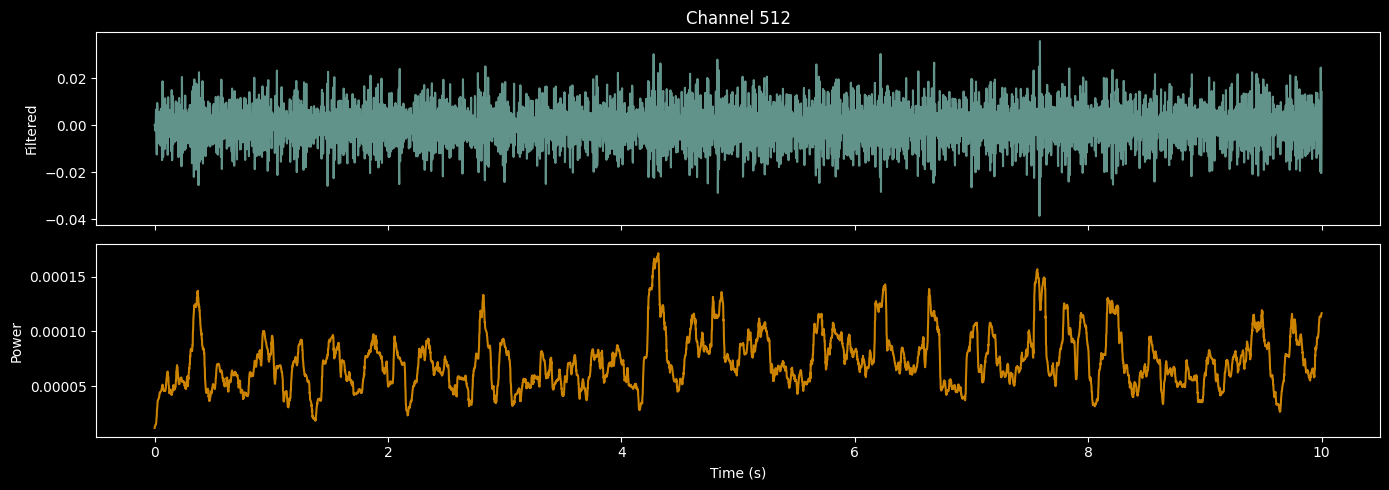

In [9]:
# Visualize power for one channel
ch = 512
t_start, t_end = 0, 10
idx = (times >= t_start) & (times <= t_end)

fig, axes = plt.subplots(2, 1, figsize=(14, 5), sharex=True)
axes[0].plot(times[idx], filtered[idx, ch], alpha=0.7)
axes[0].set_ylabel('Filtered')
axes[0].set_title(f'Channel {ch}')

axes[1].plot(times[idx], power_smooth[idx, ch], alpha=0.8, color='orange')
axes[1].set_ylabel('Power')
axes[1].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

## Step 3: Heatmap at a Single Timepoint

In [10]:
def power_to_grid(power_1024, sigma=0.0):
    """Reshape 1024 channels to 32x32 grid with optional smoothing."""
    grid = power_1024.reshape(32, 32)
    if sigma > 0:
        grid = gaussian_filter(grid, sigma=sigma)
    return grid

def plot_heatmap(grid, title='', vmin=None, vmax=None, gt_pos=None):
    """Plot 32x32 heatmap with optional ground truth overlay."""
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(grid, cmap='hot', vmin=vmin, vmax=vmax, origin='upper')
    plt.colorbar(im, ax=ax, fraction=0.046)
    
    if gt_pos is not None:
        # gt_pos is dict with keys like 'vx_pos_center_row', etc.
        colors = {'vx_pos': 'cyan', 'vx_neg': 'blue', 'vy_pos': 'lime', 'vy_neg': 'green'}
        for key, color in colors.items():
            row = gt_pos.get(f'{key}_center_row')
            col = gt_pos.get(f'{key}_center_col')
            if row is not None and col is not None:
                # Ground truth is 1-indexed, convert to 0-indexed
                ax.scatter(col - 1, row - 1, c=color, s=200, marker='x', linewidths=3, label=key)
    
    ax.set_title(title)
    ax.legend(loc='upper right')
    plt.show()

t=5.0s, vx=20.67, vy=-78.64


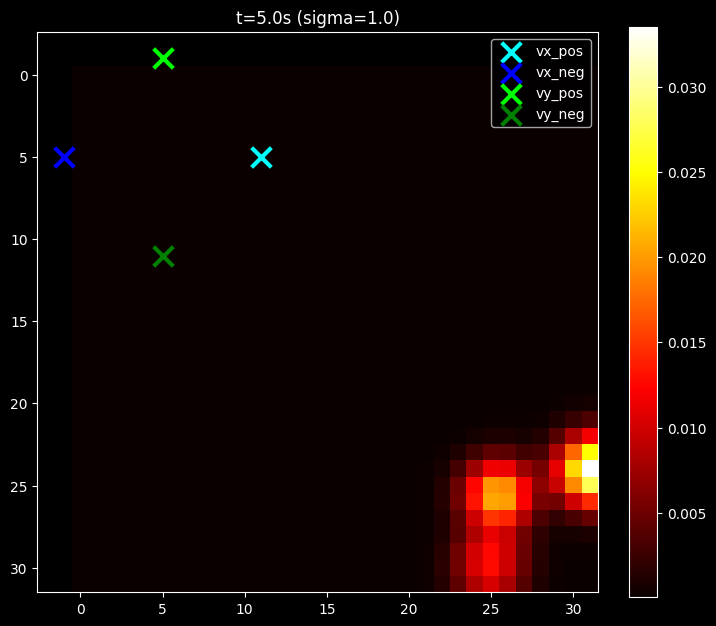

In [11]:
# Pick a timepoint
t_target = 5.0
t_idx = np.argmin(np.abs(times - t_target))

# Get power at this time
power_snapshot = power_smooth[t_idx, :]
grid = power_to_grid(power_snapshot, sigma=1.0)

# Get ground truth positions
gt_idx = np.argmin(np.abs(ground_truth['time_s'].values - t_target))
gt_row = ground_truth.iloc[gt_idx]
gt_pos = {
    'vx_pos_center_row': gt_row['vx_pos_center_row'],
    'vx_pos_center_col': gt_row['vx_pos_center_col'],
    'vx_neg_center_row': gt_row['vx_neg_center_row'],
    'vx_neg_center_col': gt_row['vx_neg_center_col'],
    'vy_pos_center_row': gt_row['vy_pos_center_row'],
    'vy_pos_center_col': gt_row['vy_pos_center_col'],
    'vy_neg_center_row': gt_row['vy_neg_center_row'],
    'vy_neg_center_col': gt_row['vy_neg_center_col'],
}

print(f"t={t_target}s, vx={gt_row['vx']:.2f}, vy={gt_row['vy']:.2f}")
plot_heatmap(grid, f't={t_target}s (sigma=1.0)', gt_pos=gt_pos)

## Step 4: Log-Normalized Power (Current Pipeline)

In [12]:
# The current pipeline uses dual EMA for baseline normalization
# Fast EMA tracks recent activity, slow EMA tracks baseline
# Output = log(fast) - log(baseline) -> positive = above baseline

def compute_dual_ema(power, alpha_fast=0.2, alpha_base=0.01):
    """Compute dual EMA normalization."""
    n_samples, n_channels = power.shape
    
    p_fast = np.zeros((n_samples, n_channels))
    p_base = np.zeros((n_samples, n_channels))
    
    p_fast[0] = power[0]
    p_base[0] = power[0]
    
    for i in range(1, n_samples):
        p_fast[i] = alpha_fast * power[i] + (1 - alpha_fast) * p_fast[i-1]
        p_base[i] = alpha_base * power[i] + (1 - alpha_base) * p_base[i-1]
    
    # Log-normalized
    normalized = np.log(p_fast + 1e-12) - np.log(p_base + 1e-12)
    
    return p_fast, p_base, normalized

# Using instant power (not pre-smoothed)
p_fast, p_base, normalized = compute_dual_ema(power_instant, alpha_fast=0.2, alpha_base=0.01)

print(f"Normalized range: [{normalized.min():.2f}, {normalized.max():.2f}]")

Normalized range: [-9.03, 2.99]


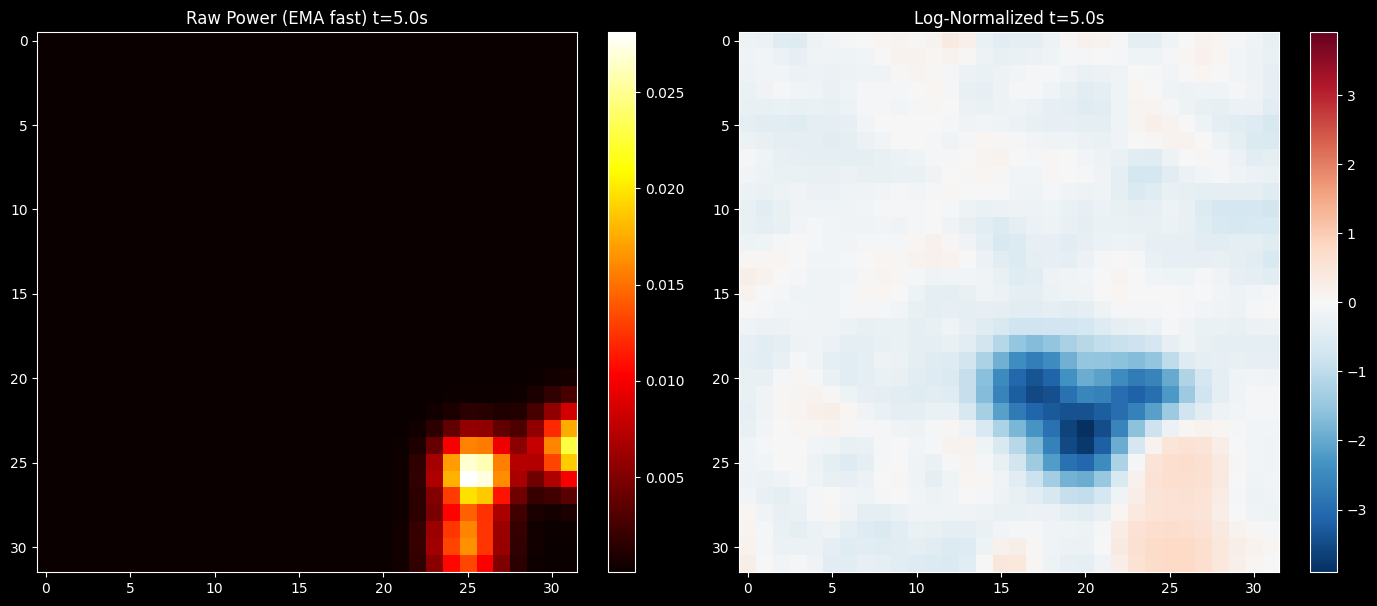

In [13]:
# Compare raw power vs log-normalized
t_target = 5.0
t_idx = np.argmin(np.abs(times - t_target))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Raw power
grid_raw = power_to_grid(p_fast[t_idx], sigma=1.0)
im0 = axes[0].imshow(grid_raw, cmap='hot', origin='upper')
axes[0].set_title(f'Raw Power (EMA fast) t={t_target}s')
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# Log-normalized
grid_norm = power_to_grid(normalized[t_idx], sigma=1.0)
vmax = max(abs(grid_norm.min()), abs(grid_norm.max()))
im1 = axes[1].imshow(grid_norm, cmap='RdBu_r', vmin=-vmax, vmax=vmax, origin='upper')
axes[1].set_title(f'Log-Normalized t={t_target}s')
plt.colorbar(im1, ax=axes[1], fraction=0.046)

plt.tight_layout()
plt.show()

## Step 5: Animation Over Time

In [14]:
from IPython.display import clear_output
import time as time_module

def animate_heatmaps(data_array, times, ground_truth, start_t=0, end_t=10, step=0.1, sigma=1.0):
    """Animate heatmaps over time."""
    for t in np.arange(start_t, end_t, step):
        clear_output(wait=True)
        
        t_idx = np.argmin(np.abs(times - t))
        grid = power_to_grid(data_array[t_idx], sigma=sigma)
        
        # Get ground truth
        gt_idx = np.argmin(np.abs(ground_truth['time_s'].values - t))
        gt_row = ground_truth.iloc[gt_idx]
        gt_pos = {
            'vx_pos_center_row': gt_row['vx_pos_center_row'],
            'vx_pos_center_col': gt_row['vx_pos_center_col'],
            'vx_neg_center_row': gt_row['vx_neg_center_row'],
            'vx_neg_center_col': gt_row['vx_neg_center_col'],
            'vy_pos_center_row': gt_row['vy_pos_center_row'],
            'vy_pos_center_col': gt_row['vy_pos_center_col'],
            'vy_neg_center_row': gt_row['vy_neg_center_row'],
            'vy_neg_center_col': gt_row['vy_neg_center_col'],
        }
        
        vmax = max(abs(grid.min()), abs(grid.max()), 0.1)
        plot_heatmap(grid, f't={t:.2f}s vx={gt_row["vx"]:.2f} vy={gt_row["vy"]:.2f}', 
                     vmin=-vmax, vmax=vmax, gt_pos=gt_pos)
        
        time_module.sleep(0.1)

# Uncomment to run animation:
# animate_heatmaps(normalized, times, ground_truth, start_t=0, end_t=10, step=0.2)

## Step 6: Check If Signal Correlates With Movement

In [15]:
# For each ground truth region, check if the channels near it have higher power
# when the corresponding velocity is high

def get_channels_near(row, col, radius=3, grid_size=32):
    """Get channel indices near a grid position (0-indexed)."""
    channels = []
    for r in range(max(0, int(row)-radius), min(grid_size, int(row)+radius+1)):
        for c in range(max(0, int(col)-radius), min(grid_size, int(col)+radius+1)):
            if (r - row)**2 + (c - col)**2 <= radius**2:
                channels.append(r * grid_size + c)
    return channels

# Sample: look at vx+ region when vx > 0
vx = ground_truth['vx'].values
vy = ground_truth['vy'].values

# Resample power to ground truth times
gt_times = ground_truth['time_s'].values
power_at_gt = np.array([p_fast[np.argmin(np.abs(times - t))] for t in gt_times])

# Get mean power in vx+ region over time
vx_pos_power = []
for i, t in enumerate(gt_times):
    row = ground_truth.iloc[i]['vx_pos_center_row'] - 1  # 0-indexed
    col = ground_truth.iloc[i]['vx_pos_center_col'] - 1
    chs = get_channels_near(row, col, radius=3)
    vx_pos_power.append(power_at_gt[i, chs].mean())

vx_pos_power = np.array(vx_pos_power)

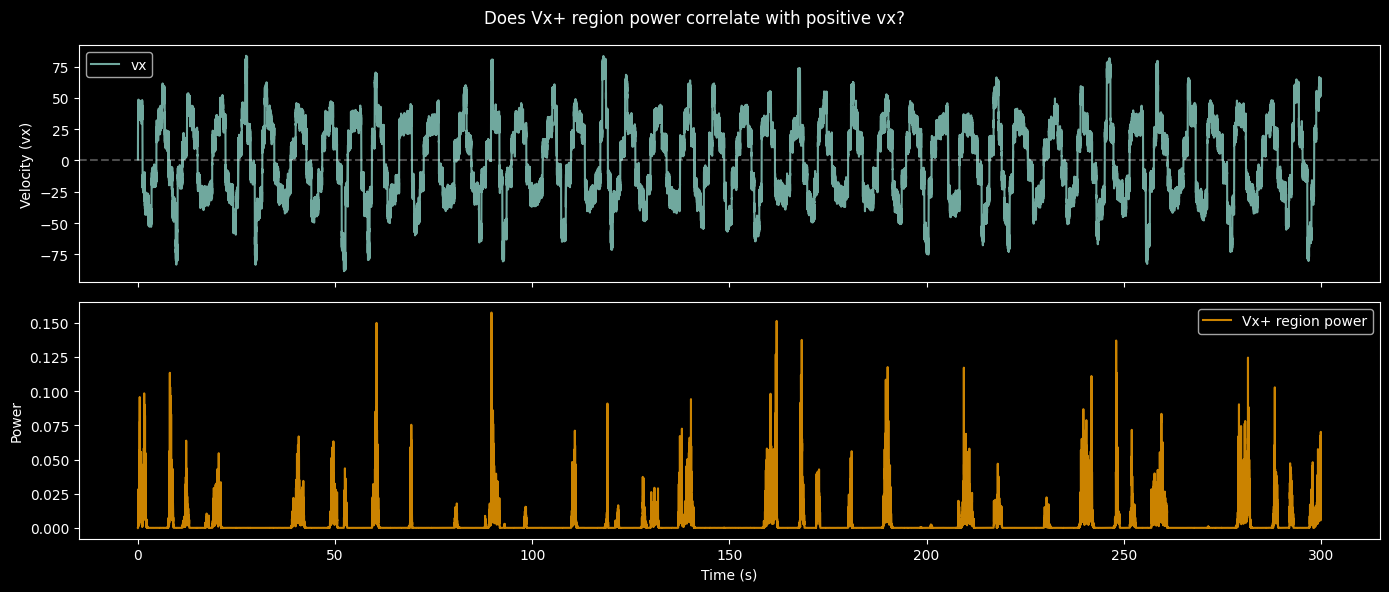

Correlation between vx and Vx+ region power: 0.211


In [16]:
# Plot vx velocity vs vx+ region power
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

axes[0].plot(gt_times, vx, label='vx', alpha=0.8)
axes[0].axhline(0, color='white', linestyle='--', alpha=0.3)
axes[0].set_ylabel('Velocity (vx)')
axes[0].legend()

axes[1].plot(gt_times, vx_pos_power, label='Vx+ region power', alpha=0.8, color='orange')
axes[1].set_ylabel('Power')
axes[1].set_xlabel('Time (s)')
axes[1].legend()

plt.suptitle('Does Vx+ region power correlate with positive vx?')
plt.tight_layout()
plt.show()

# Correlation
corr = np.corrcoef(vx, vx_pos_power)[0, 1]
print(f"Correlation between vx and Vx+ region power: {corr:.3f}")

## Experiment: Try Different Parameters

In [ ]:
# Try different bandpass ranges
bandpass_ranges = [
    (70, 150),   # high gamma (current)
    (30, 70),    # low gamma
    (8, 30),     # alpha/beta
    (1, 250),    # broadband
]

fig, axes = plt.subplots(1, len(bandpass_ranges), figsize=(16, 4))

t_target = 5.0
t_idx = np.argmin(np.abs(times - t_target))

for ax, (low, high) in zip(axes, bandpass_ranges):
    sos = make_bandpass(low, high, fs, order=4)
    filt = sosfilt(sos, neural, axis=0)
    pwr = filt ** 2
    
    # Simple smoothing
    kernel = np.ones(50) / 50
    pwr_smooth = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), 0, pwr)
    
    grid = power_to_grid(pwr_smooth[t_idx], sigma=1.0)
    im = ax.imshow(grid, cmap='hot', origin='upper')
    ax.set_title(f'{low}-{high} Hz')

plt.suptitle(f't={t_target}s - Different Frequency Bands')
plt.tight_layout()
plt.show()